## ChatBot with Tools

In [1]:
from langchain_tavily import TavilySearch
import os
from dotenv import load_dotenv
load_dotenv()

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
   'title': 'What is LangGraph? - Analytics Vidhya',
   'content': '* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain framework was the main tool for building and executing AI agents before LangGraph. Large Language Models (LLMs) are the foundation for designing sophisticated AI agents, and LangGraph, built on top of Langchain, is intended to make the process of creating cyclic graphs easier. Ans. LangGraph addresses the limitations of previous AI agent development frameworks by provi

In [2]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

## Custom Function (Tool Function)

In [3]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [4]:
tools = [tool, multiply]

In [5]:
llm_with_tool = llm.bind_tools(tools)

In [6]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x107fcb3d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10890ec50>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

# Build a State Graph

In [7]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
# State definition
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

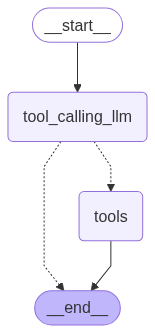

In [8]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [10]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial Intelligence | TechCrunch", "content": "### Elon Musk’s xAI sues Apple and OpenAI, alleging anticompetitive collusion\\n\\nGreg Brockman\\n\\n### Silicon Valley is pouring millions into pro-AI PACs to sway midterms\\n\\nImage of the RM5.\\n\\n### Robomart unveils new delivery robot with $3 flat fee to challenge DoorDash, Uber Eats\\n\\nThe Grok app on a smartphone\\n\\n### Elon Musk says xAI has open sourced Grok 2.5\\n\\nthe logos of Open AI displayed on both computer and smart phone screen\\n\\n### OpenAI warns against SPVs and other ‘unauthorized’ investments [...] ### Anthropic settles AI book-training lawsuit with authors\\n\\nLip-Bu Tan, Intel, Trump administration\\n\\n### Why the US government is not the savior Intel needs\\n\\nAmazon Kindle e-reader laying on a wooden surface\\n\\n

In [11]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (zcdgedwgg)
 Call ID: zcdgedwgg
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial Intelligence | TechCrunch", "content": "### Elon Musk’s xAI sues Apple and OpenAI, alleging anticompetitive collusion\n\nGreg Brockman\n\n### Silicon Valley is pouring millions into pro-AI PACs to sway midterms\n\nImage of the RM5.\n\n### Robomart unveils new delivery robot with $3 flat fee to challenge DoorDash, Uber Eats\n\nThe Grok app on a smartphone\n\n### Elon 

In [12]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (g52xgpv0b)
 Call ID: g52xgpv0b
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [14]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (xbtm0masg)
 Call ID: xbtm0masg
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.forbes.com/sites/markminevich/2025/08/26/ais-1-trillion-shakeout-bubble-correction-or-market-reset/", "title": "AI’s $1 Trillion Shakeout: Bubble, Correction, Or Market Reset - Forbes", "score": 0.78413767, "published_date": "Wed, 27 Aug 2025 00:32:46 GMT", "content": "In recent weeks, AI investors and enterprise leaders have felt the yo-yo effect of the AI market. On Monday, August 6th, alone, tech’s megacap companies lo